In [1]:
from datetime import datetime
start_time = datetime.now() # initialize timer
import matplotlib.pyplot as pl
import numpy as np
import scipy.optimize as op
import os
import astropy.units as u
import sys
from scipy.stats import chisquare
from datetime import datetime
from astropy.coordinates import SkyCoord
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit
import emcee

In [2]:
class color:
   PURPLE = '\033[1;35;48m'
   CYAN = '\033[1;36;48m'
   BOLD = '\033[1;37;48m'
   BLUE = '\033[1;34;48m'
   GREEN = '\033[1;32;48m'
   YELLOW = '\033[1;33;48m'
   RED = '\033[1;31;48m'
   BLACK = '\033[1;30;48m'
   UNDERLINE = '\033[4;37;48m'
   END = '\033[1;37;0m'

In [3]:
local_path='/Users/adrianhernandez/JPL_2021/'
sys.path.append(local_path + 'MulensModel_master/source')
import MulensModel as mm
from MulensModel.utils import Utils
import mcmcFit as mcfit

In [16]:
from glob import glob
im_dir = '/Users/adrianhernandez/JPL_2021/ukirt_files/'
ukirt_file = glob(f"{im_dir}/*C28997*.txt")
print(ukirt_file[0]) #change indicies to update the file you are interested 
filename = ukirt_file[0][44:76]
ukirt_data_K = np.loadtxt(ukirt_file[0], usecols=range(3))
ukirt_data_H = np.loadtxt(ukirt_file[2], usecols=range(3))
K_data = mm.MulensData(file_name=ukirt_file[0])
H_data = mm.MulensData(file_name=ukirt_file[2])

print(filename)

/Users/adrianhernandez/JPL_2021/ukirt_files/UK2018_c1_4_3_K_C28997.txt
UK2018_c1_4_3_K_C28997.txt


In [26]:
data = np.concatenate((ukirt_data_H,ukirt_data_K))

#create arrays for time, magnitude, and error 
time = data[:,0] # - 2450000 for ukirt data 
mag = data[:,1]
error = data[:,2]
data_points = len(data)

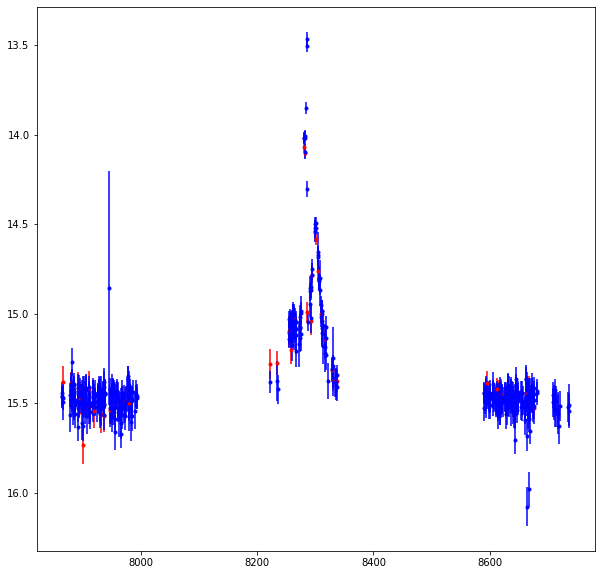

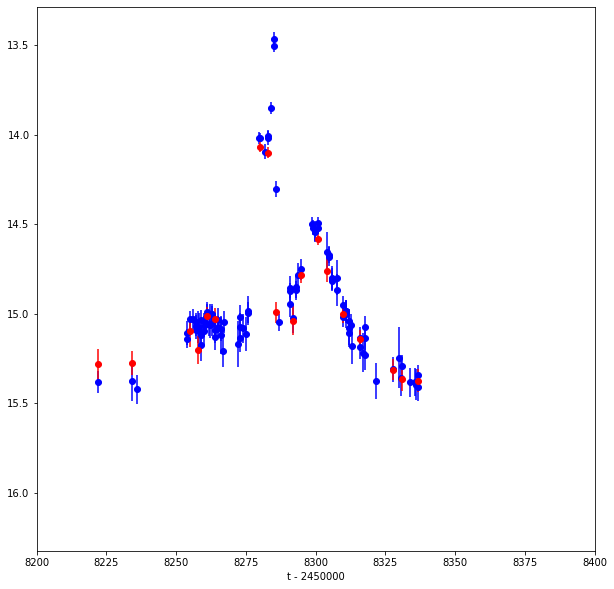

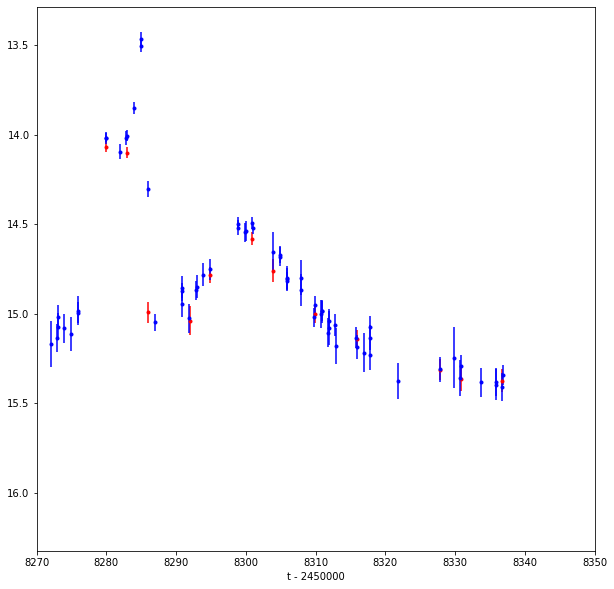

In [25]:
# Plot the data
pl.figure(figsize=(10,10))
pl.errorbar(H_data.time-2450000, H_data.mag, yerr=H_data.err_mag, fmt='.r')
pl.errorbar(K_data.time-2450000, K_data.mag, yerr=K_data.err_mag, fmt='.b')
pl.gca().invert_yaxis()
pl.show()

# ***Define plot limits for a zoom (of the planetary perturbation)***
(t_min, t_max) = (8200,8400)

# Plot a zoom of the data
pl.figure(figsize=(10,10))
pl.errorbar(K_data.time-2450000, K_data.mag, yerr=K_data.err_mag, fmt='ob')
pl.errorbar(H_data.time-2450000, H_data.mag, yerr=H_data.err_mag, fmt='or')
pl.xlim(t_min, t_max)
pl.xlabel('t - 2450000')
# pl.axvline(x = 8300)
# pl.axvline(x = 8288)
# pl.axvline(x = 8286.99471) 
pl.gca().invert_yaxis()
pl.show()

pl.figure(figsize=(10,10))
pl.errorbar(H_data.time-2450000, H_data.mag, yerr=H_data.err_mag, fmt='.r')
pl.errorbar(K_data.time-2450000, K_data.mag, yerr=K_data.err_mag, fmt='.b')
pl.xlim(t_min, t_max)
pl.xlabel('t - 2450000')
pl.xlim(8270,8350)
pl.gca().invert_yaxis()
pl.show()

In [28]:
base_est = np.mean(mag) 
print(color.BLUE +'Estimated Baseline magnification ='+ color.END,base_est)
peak_est = min(mag)
print(color.BLUE +'Estimated Event peak magnification ='+ color.END,peak_est)
del_mag_est = base_est - 14.5 #base_est - peak_est 
print(color.BLUE +'Estimated Change in magnification ='+ color.END,del_mag_est)
to_est = 2458305 #time[mag.argmin()] #2458588.82653
print(color.BLUE +'Estimated Time at which peak magnification occurs ='+ color.END,to_est)
A_FWHM = (base_est + 14.5)/2
print(color.BLUE +'FWHM occurs at'+ color.END,A_FWHM)
width = np.full((1,data_points),A_FWHM)
idx = np.argwhere(np.diff(np.sign(width - mag))).flatten()
print(time[idx])
FWHM = time[idx][19]-time[idx][5]
print(color.BLUE +'The estimated FWHM is'+ color.END,FWHM)
sig_est = FWHM/2.355
print(color.BLUE +'The estimated simga is'+ color.END,sig_est)

Estimated Baseline magnification = 15.35230612244898
Estimated Event peak magnification = 13.468
Estimated Change in magnification = 0.8523061224489794
Estimated Time at which peak magnification occurs = 2458305
FWHM occurs at 14.92615306122449
[2458222.08713 2458263.9769  2458222.08713 2458282.93119 2458222.08713
 2458291.92926 2458222.08713 2458303.96727 2458222.08713 2458275.92778
 2458222.08713 2458285.90622 2458222.08713 2458290.87243 2458222.08713
 2458290.8757  2458222.08713 2458291.87047 2458222.08713 2458307.85825
 2458222.08713 2457937.93594 2458222.08713 2457944.85766]
The estimated FWHM is 15.92898999992758
The estimated simga is 6.763902335425724


In [29]:
A = 10**((del_mag_est)/2.5) 
print(color.PURPLE +'Magnification increased by'+ color.END,A)
u0_est = 1/A
print(color.PURPLE +'Estimated minimum event separation, u0 ='+ color.END,u0_est)
t0_est = 2458305 ##time[ukirt_mag.argmin()]+2450000 #2458588.82653
print(color.PURPLE +'Estimated Time at which peak magnification occurs, t0 ='+ color.END,t0_est)
width = np.full((1,data_points),A_FWHM)
idx = np.argwhere(np.diff(np.sign(width - mag))).flatten()
print(time[idx])
tE_est = time[idx][19]-time[idx][5]
print(color.PURPLE +'The estimated Einstein crossing time is, tE'+ color.END,tE_est)

Magnification increased by 2.19241340590402
Estimated minimum event separation, u0 = 0.4561183567419667
Estimated Time at which peak magnification occurs, t0 = 2458305
[2458222.08713 2458263.9769  2458222.08713 2458282.93119 2458222.08713
 2458291.92926 2458222.08713 2458303.96727 2458222.08713 2458275.92778
 2458222.08713 2458285.90622 2458222.08713 2458290.87243 2458222.08713
 2458290.8757  2458222.08713 2458291.87047 2458222.08713 2458307.85825
 2458222.08713 2457937.93594 2458222.08713 2457944.85766]
The estimated Einstein crossing time is, tE 15.92898999992758


original PARAMS:  {'u0': 0.4561183567419667, 't0': 8305, 'tE': 15.92898999992758, 'Ftot': 15.458, 'fb': 0.99, 'chi2': 1, 'chi2red': 1}
initializing walkers
('OK: smaller range2 for JD init', 8305)
running mcmc for ground-based data
 setting the burn in
 doing the final run
(' Acceptance fraction:', 0.2902777777777778)
 not doing the autocorr check.  trouble here!
('FIT RESULT:', '      u0', '=', '      0.0017', '+-', ' 0.00107')
(' | chi offset =', '-423.91')
  0.0
('FIT RESULT:', '      tE', '=', '   1832.4053', '+-', '1309.59668')
(' | chi offset =', ' 1.39')
  0.0
('FIT RESULT:', '      t0', '=', '   8281.9884', '+-', ' 0.08009')
(' | chi offset =', '-287.33')
  0.0
('FIT RESULT:', '    Ftot', '=', '     15.4902', '+-', ' 0.00315')
(' | chi offset =', '10.24')
  0.0
('FIT RESULT:', '      fb', '=', '      0.0050', '+-', ' 0.00319')
(' | chi offset =', '-308.96')
  0.0
None
bestIndex 8866
 param old,new values: u0 0.001682718055788287 0.0003768869241562225
 param old,new values: tE 1

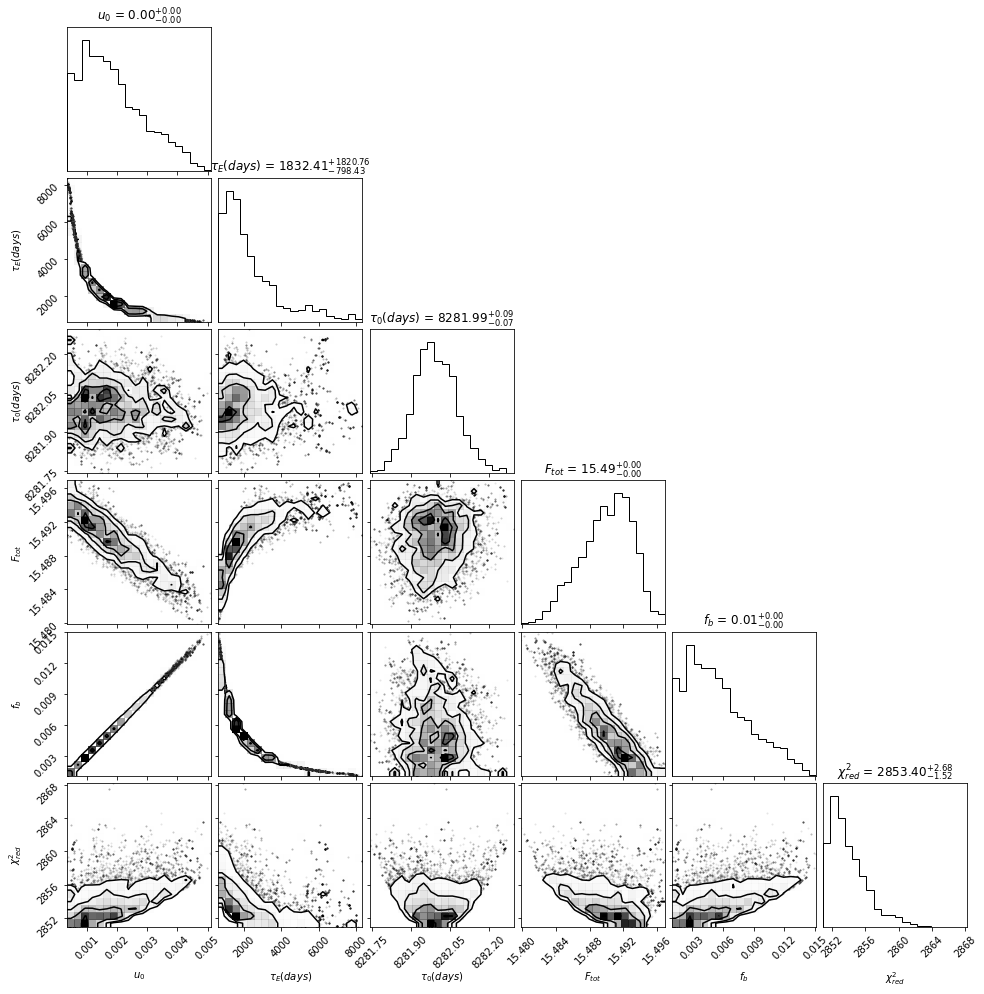

In [30]:
import mcmcFit as mcfit

u0,t0,tE,Ftot,fb,u0err,t0err,tEerr,Ftoterr,fberr = mcfit.mcmcFit(filename,time -2450000, mag, error,u0_est,t0_est-2450000,tE_est)

print('u0, error',u0,u0err)
print('t0, error',t0,t0err)
print('tE, error',tE,tEerr)
print('Ftot, error',Ftot,Ftoterr)
print('Fb, error',fb,fberr)